In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
%%time
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

from scipy.ndimage import gaussian_filter1d


CPU times: user 6.72 s, sys: 1.39 s, total: 8.1 s
Wall time: 10.3 s


## define functions

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

## load data sets


In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [5]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w0,axis=0))


ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


In [6]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_CTRL['temp_doy']=ds_CTRL.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['my_doy']=ds_CTRL.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_CTRL['u_rho_doy']=ds_CTRL.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_CTRL['v_rho_doy']=ds_CTRL.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


In [7]:
ds_CTRL

<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(32, 750, 900), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 750, 900), meta=np.ndarray>
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/105)
    ntimes             int32 ...
    ndtfast            int32 ...
    dt                 float64 ...
    dtfast             float64 ...
    dstart             datetime64[ns] ...
    nHIS               int32 ...
    ...                 ...
    dy_u               (eta_rho, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    dy_v               (eta_v, xi_rho) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    dy_psi             (eta_v, xi_u) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
    dA                 (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 750, 900), meta=np.ndarray>
    my_doy             (dayofyear, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [8]:
frc = xr.open_dataset('../../frc/amery_v2km_tamura+era_shflux.nc')


/jobfs/131858639.gadi-pbs/ipykernel_2880962/3778512502.py:90: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p = cs.collections[0].get_paths()[0]


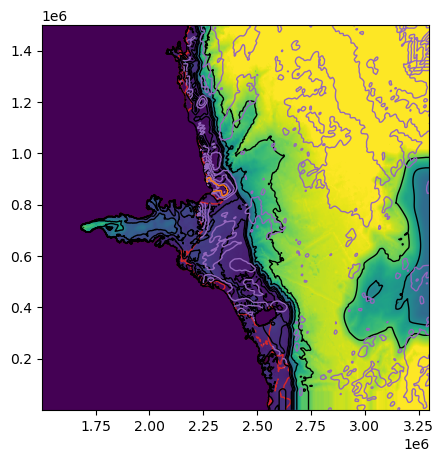

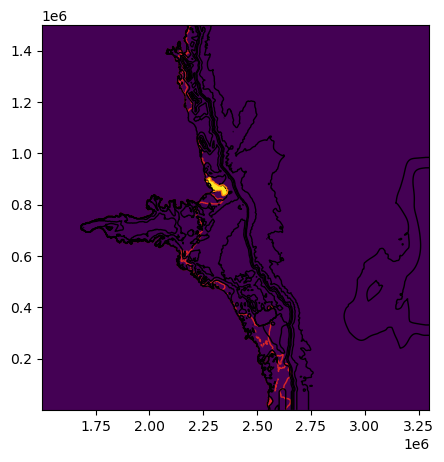

In [9]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

# paths = cs.get_paths()[0].to_polygons()
# plt.plot(paths[1][:,0],paths[1][:,1])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley
# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



In [10]:
%%time

# dump the big fields
ds_CTRL = ds_CTRL.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my'])
print(ds_CTRL.nbytes/1e9,'G')
ds_CTRL.load()

7.223673352 G
CPU times: user 1min 47s, sys: 1min 41s, total: 3min 28s
Wall time: 1min 41s


<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w                (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 1.502e+06 1.504e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 -76.25 -76.23 ... -57.53 -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -3.873
  * day                (day) int64 356 361 1 6 11 16 ... 326 331 336 341 346 351
  * dayofyear          (dayofyear) int64 1 6 11 16 21 26 ... 341 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/94)
    ntimes             int32 131400
    ndtfast            int32 40
    dt                 float64 240.0
    dtfast             float64 6.0
    dstart             datetime64[ns] 2007-01-01
    nHIS               int32 1800
    ...                 ...
    dy_u               (eta_rho, xi_u) float64 2.018e+03 2.018e+03 ... 1.889e+03
    dy_v               (eta_v, xi_rho) float64 2.018e+03 2.018e+03 ... 1.889e+03
    dy_psi             (eta_v, xi_u) float64 2.018e+03 2.018e+03 ... 1.889e+03
    dA                 (eta_rho, xi_rho) float64 4.073e+06 ... 3.574e+06
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 nan ... 34.33
    my_doy             (dayofyear, eta_rho, xi_rho) float64 nan nan ... 0.0 0.0
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [11]:
# define time periods
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period)[-1].values)

winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[-1].values)


late_summer_period=slice(20,80)
early_seaice_period=slice(80,130)
seaice_period=slice(130,330)
early_summer_period1=slice(330,366)
early_summer_period2=slice(0,20)


256  to  316
71  to  131
246  to  306
61  to  121


### load any other data sets

In [12]:
# now load lima

import rioxarray

lima_full = rioxarray.open_rasterio('../data/raw/lima/00000-20080319-092059124.tif')

lima = lima_full.where((lima_full.x>1.68e6)&(lima_full.x<2.5e6)&(lima_full.y>.4e6)&(lima_full.y<1e6),drop=True)


### begin analysis

Text(0.5, 0, 'Day of year')

<Figure size 640x480 with 0 Axes>

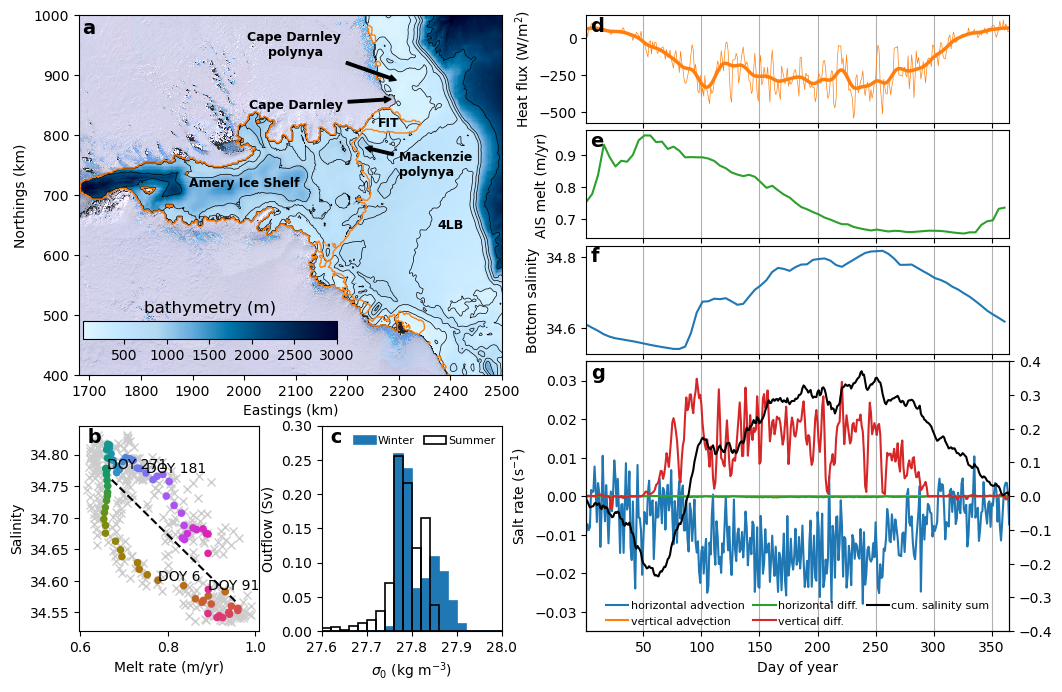

In [19]:
# test plot salt in SDW period


plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,8])
ax = None

gs0 = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.20, hspace=0.14)

gs00 = gs0[0].subgridspec(2, 2,wspace=0.35, hspace=0.18,height_ratios=[0.7,0.4])


from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap with more colors
colors = [
    '#000033',  # Deepest ocean (very dark blue)
    '#00224d',  # Very deep ocean (dark blue)
    '#004477',  # Mid-depth ocean (blue with a hint of warmth)
    '#0077aa',  # Shallower ocean (warmer blue)
    '#66aadd',  # Shallow ocean (light blue)
    '#b3d9f2',  # Near sea level (very pale blue)
    '#c2e7ff',  # Very shallow water (light yellowy-blue)
    '#e0f7ff',  # Near-surface (almost white with a blue hue)
]



# Create the colormap
custom_bathy_cmap = LinearSegmentedColormap.from_list("custom_bathy", colors)
flipped_bathy_cmap = custom_bathy_cmap.reversed()

ax=fig.add_subplot(gs00[0,:])
(lima.astype('uint8')).plot.imshow()
# im1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
# im2 = (ds.mask_rho*(ds.mask_rhoNaN)*ds.salt_doy.isel(s_rho=0).isel(dayofyear=summer_period).mean(dim='dayofyear')).plot(ax=ax,x='x_rho',y='y_rho',cmap='viridis',
#                                                                                                                       vmin=34.3,vmax=34.9,add_colorbar=False)
im1 = (ds.h*ds.mask_rhoNaN).plot(ax=ax,x='x_rho',y='y_rho',cmap=flipped_bathy_cmap,vmin=20,vmax=3000,add_colorbar=False)

# co1 = (ds_dailyclima.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds.h*ds.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=.5)
co3 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="60%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.01,0.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
cax.set_title(r'bathymetry (m)')#,fontsize=14)




ax.annotate("Amery Ice Shelf",
            xy=(1.80e6, 720e3), xycoords='data',
            xytext=(2.00e6, 720e3), textcoords='data',fontweight='bold',
            size=9, va="center", ha="center")

ax.annotate("4LB",
            xy=(1.80e6, 720e3), xycoords='data',
            xytext=(2.40e6, 650e3), textcoords='data',fontweight='bold',
            size=9, va="center", ha="center")

ax.annotate("Mackenzie \npolynya",
            xy=(2.230e6, 780e3), xycoords='data',
            xytext=(2.30e6, 750e3), textcoords='data',
            size=9, va="center", ha="left",fontweight='bold',
            arrowprops=dict(arrowstyle="simple",
                           facecolor="black"))

ax.annotate("FIT",
            xy=(2.230e6, 780e3), xycoords='data',
            xytext=(2.260e6, 820e3), textcoords='data',fontweight='bold',
            size=9, va="center", ha="left")

ax.annotate("Cape Darnley",
            xy=(2.290e6, 860e3), xycoords='data',
            xytext=(2.10e6, 850e3), textcoords='data',
            size=9, va="center", ha="center",fontweight='bold',
            arrowprops=dict(arrowstyle="simple",
                           facecolor="black"))

ax.annotate("Cape Darnley \npolynya",
            xy=(2.30e6, 890e3), xycoords='data',
            xytext=(2.10e6, 950e3), textcoords='data',
            size=9, va="center", ha="center",fontweight='bold',
            arrowprops=dict(arrowstyle="simple",
                           facecolor="black"))


ax=fig.add_subplot(gs00[1,0])
plty = ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))
pltx = ds_CTRL.my_doy.where(ds_CTRL.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))
# time_values=ds.ocean_time.values
# start_of_year = np.datetime64('2048-01-01')
# days_diff = (time_values - start_of_year).astype('timedelta64[D]').astype(float)
# fractional_days = (time_values - time_values.astype('datetime64[D]')).astype('timedelta64[ns]').astype(float) / (24 * 60 * 60 * 1e9)
# pltt = days_diff+fractional_days
# pltt = (pltt - 365) % 365
pltt = ds_CTRL.dayofyear.values
m,b = np.polyfit(pltx, plty,deg=1)
pltx_i = np.arange(pltx.min(),pltx.max(),0.001)
plt1=ax.plot(ds.my.where(ds_CTRL.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')),ds.salt.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),'x',color='0.8')
sc=ax.scatter(pltx,plty,s=20,c=pltt,cmap='cmo.phase',zorder=10)
ax.plot(pltx_i,m*pltx_i+b, '--k')

for nn in np.array([1,18,36,54]):
    ax.annotate('DOY '+str(ds_CTRL.dayofyear.values[nn]),xy=(pltx.values[nn],plty.values[nn]),xycoords='data',zorder=11)
ax.text(0.01, 0.99, ' b ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Melt rate (m/yr)')
ax.set_ylabel('Salinity')

outflow_CTRL = xr.open_dataarray('../data/proc/CTRL_outflow_pos.nc')

ax=fig.add_subplot(gs00[1,1])
ax.hist(outflow_CTRL.dens_class,weights=outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_CTRL.dens_class,edgecolor='C0', stacked=True, label='Winter',linewidth=1.2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_CTRL.isel(dayofyear=summer_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_CTRL.dens_class,edgecolor='k', stacked=True, fill=False, label='Summer',linewidth=1.2)
ax.legend(frameon=False,loc='upper center', bbox_to_anchor=(0.57, 1), ncol=2,fontsize=8,handletextpad=0.2, columnspacing=0.8)
ax.text(0.01, 0.99, ' c ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Outflow (Sv)')
ax.set_xlabel('$\sigma_0$ (kg m$^{-3}$)')
ax.set_ylim((0,0.3))
ax.set_xlim((27.6,28))


gs01 = gs0[1].subgridspec(4, 1,wspace=0.035, hspace=0.05,height_ratios=[0.1,0.1,0.1,0.25])


ax=fig.add_subplot(gs01[0,0])
ax.xaxis.grid(True)
plt.plot(frc.shf_time,frc.shflux.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=.5,label='shflux - CD')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')), 5),color='C1',linewidth=2.5,label='Cape Darnley (5-day filter)')
# plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=.5,label='shflux - Ma')
# plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=2.5,label='shflux - Ma (5-day filter)')
ax.text(0.01, 0.99, 'd ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Heat flux (W/m$^{2}$)')
ax.set_title('')
ax.set_xlim((1,365))

ax=fig.add_subplot(gs01[1,0])
ax.xaxis.grid(True)
ds_CTRL.my_doy.where(ds_CTRL.mask_zice_roi==1).weighted(weights).mean(('xi_rho','eta_rho')).plot(ax=ax,color='C2', linewidth=1.5,label='AIS (CTRL)')
# (ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0', linewidth=1.5)
ax.text(0.01, 0.99, 'e  ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('AIS melt (m/yr)')
ax.set_title('')
ax.set_xlim((1,365))

ax=fig.add_subplot(gs01[2,0])
ax.xaxis.grid(True)
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='CTRL')
# ds.salt_doy.isel(s_rho=0).isel(xi_rho=390,eta_rho=440).plot(color='C1',linewidth=1.5)
# ds.salt_doy.isel(s_rho=0).isel(xi_rho=362,eta_rho=391).plot(color='C2',linewidth=1.5)
ax.text(0.01, 0.99, 'f  ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Bottom salinity')
ax.set_title('')
ax.set_xlim((1,365))



salt_hadv_int = xr.open_dataarray('../data/proc/amery_DIAG_salt_hadv_int.nc')
salt_vadv_int = xr.open_dataarray('../data/proc/amery_DIAG_salt_vadv_int.nc')
salt_hdiff_int = xr.open_dataarray('../data/proc/amery_DIAG_salt_hdiff_int.nc')
salt_vdiff_int = xr.open_dataarray('../data/proc/amery_DIAG_salt_vdiff_int.nc')
salt_rate_int = xr.open_dataarray('../data/proc/amery_DIAG_salt_rate_int.nc')

ax=fig.add_subplot(gs01[3,0])
ax.xaxis.grid(True)

salt_hadv_int.where(grd.mask_capedarnley==1).sum(('xi_rho','eta_rho')).plot(x='dayofyear',label='horizontal advection')
salt_vadv_int.where(grd.mask_capedarnley==1).sum(('xi_rho','eta_rho')).plot(x='dayofyear',label='vertical advection')
salt_hdiff_int.where(grd.mask_capedarnley==1).sum(('xi_rho','eta_rho')).plot(x='dayofyear',label='horizontal diff.')
salt_vdiff_int.where(grd.mask_capedarnley==1).sum(('xi_rho','eta_rho')).plot(x='dayofyear',label='vertical diff.')
ax.set_ylim(-0.035,.035)

ax2 = ax.twinx()
np.cumsum((salt_hadv_int+salt_vadv_int+salt_hdiff_int+salt_vdiff_int).where(grd.mask_capedarnley==1).sum(('xi_rho','eta_rho'))).plot(ax=ax2,label='cum. salinity sum',color='k')
ax2.set_ylim(-.4,.4)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False,loc='upper center', bbox_to_anchor=(0.5, .15), ncol=3,fontsize=8,handletextpad=0.2, columnspacing=0.8)
ax.set_xlim((1,365))


ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Salt rate (s$^{-1}$)')
ax.set_title('')
ax.set_xlabel('Day of year')
